In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.linear_model import RidgeCV
import catboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor,StackingRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
train = pd.read_csv("../input/diamonds/train.csv")
test = pd.read_csv("../input/diamonds/test.csv")

In [3]:
train.isnull().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

In [4]:
train.loc[train[(train['z']==0)|(train['z']>15)].index,'z']=train['z'].median()
train.loc[train[train['x']==0].index,'x']=train['x'].median()
train.loc[train[(train['y']==0)|(train['y']>15)].index,'y']=train['y'].median()
test.loc[test[(test['z']==0)|(test['z']>15)].index,'z']=test['z'].median()
test.loc[test[test['x']==0].index,'x']=test['x'].median()
test.loc[test[(test['y']==0)|(test['y']>15)].index,'y']=test['y'].median()

In [5]:
train['LW Ratio']=train['x']/train['y']
test['LW Ratio']=test['x']/test['y']
train['volume']=train['x']*train['y']*train['z']
test['volume']=test['x']*test['y']*test['z']

In [6]:
train.dropna(axis=0,inplace=True)
train=train.drop_duplicates()

In [7]:
train.corr()

,Unnamed: 0,carat,depth,table,price,x,y,z,LW Ratio,volume
Unnamed: 0,1.000000,-0.374606,-0.040978,-0.116833,-0.301711,-0.408180,-0.408912,-0.411621,-0.041994,-0.372273
carat,-0.374606,1.000000,0.022599,0.191260,0.923801,0.977097,0.976013,0.974723,0.147541,0.998572
depth,-0.040978,0.022599,1.000000,-0.292084,-0.014393,-0.030877,-0.033666,0.090005,0.049990,0.005576
table,-0.116833,0.191260,-0.292084,1.000000,0.136975,0.205558,0.199153,0.165654,0.150475,0.181752
price,-0.301711,0.923801,-0.014393,0.136975,1.000000,0.890033,0.891451,0.884058,0.095179,0.925376
x,-0.408180,0.977097,-0.030877,0.205558,0.890033,1.000000,0.998685,0.990293,0.161134,0.978494
y,-0.408912,0.976013,-0.033666,0.199153,0.891451,0.998685,1.000000,0.989718,0.111334,0.977843
z,-0.411621,0.974723,0.090005,0.165654,0.884058,0.990293,0.989718,1.000000,0.146411,0.975170
LW Ratio,-0.041994,0.147541,0.049990,0.150475,0.095179,0.161134,0.111334,0.146411,1.000000,0.139153
volume,-0.372273,0.998572,0.005576,0.181752,0.925376,0.978494,0.977843,0.975170,0.139153,1.000000


In [8]:
quality_map = {'Fair':0.1, 'Good':0.2, 'Very Good':0.3, 'Premium':0.4, 'Ideal':0.5}
color_map = {'D':0.7, 'E':0.6, 'F':0.5, 'G':0.4, 'H':0.3,'I':0.2,'J':0.1}
clarity_map = {'I1':0.1, 'SI2':0.2, 'SI1':0.3, 'VS2':0.4, 'VS1':0.5,'VVS2':0.6,'VVS1':0.7,'IF':0.8}

train['cut'] = train.cut.map(quality_map)
train['color'] = train.color.map(color_map)
train['clarity'] = train.clarity.map(clarity_map)
test['cut'] = test.cut.map(quality_map)
test['color'] = test.color.map(color_map)
test['clarity'] = test.clarity.map(clarity_map)

In [9]:
train = train.drop(['Unnamed: 0'] ,axis =1)

In [10]:
for feature_name in ['carat','depth','table','x','y','z','volume'] :
    median = train[feature_name].median()
    std = train[feature_name].std()
    train[feature_name] = (train[feature_name] - median) / (std)
    test[feature_name] = (test[feature_name] - median) / (std)

In [11]:
train.describe()

,carat,cut,color,clarity,depth,table,price,x,y,z,LW Ratio,volume
count,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,4.304000e+04
mean,0.180627,0.391619,0.441241,0.404761,-0.037568,0.196207,3942.706343,0.013543,0.006309,0.007314,0.999465,1.751799e-01
std,1.000000,0.111577,0.170342,0.164443,1.000000,1.000000,4023.534556,1.000000,1.000000,1.000000,0.010355,1.000000e+00
min,-1.059290,0.100000,0.100000,0.100000,-13.098796,-6.249452,326.000000,-1.751995,-1.818309,-3.524826,0.749169,-1.086639e+00
25%,-0.685423,0.300000,0.300000,0.300000,-0.557396,-0.446389,940.000000,-0.929088,-0.935894,-0.945685,0.992665,-6.858349e-01
50%,0.000000,0.400000,0.400000,0.400000,0.000000,0.000000,2388.000000,0.000000,0.000000,0.000000,0.995763,9.152276e-17
75%,0.664652,0.500000,0.600000,0.500000,0.487721,0.892779,5309.250000,0.699028,0.695236,0.702099,1.006944,6.678518e-01
max,8.931265,0.500000,0.700000,0.800000,11.984005,16.962798,18823.000000,4.450775,4.296201,6.490838,1.615572,8.682418e+00


In [12]:
train["price_cat"] = pd.cut(train["price"],bins=5,labels=[1, 2, 3, 4, 5])
split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=32)
for train_index, test_index in split.split(train, train["price_cat"]):
    Train =train.loc[train_index]
    val= train.loc[test_index]

In [13]:
for set_ in (Train, val):
    set_.drop("price_cat", axis=1, inplace=True)

In [14]:
train_y=np.log1p(Train['price'])
train_X=Train.drop("price", axis=1)
test_y=np.log1p(val['price'])
test_X=val.drop("price", axis=1)

In [15]:
id = test['Unnamed: 0']
test  =  test.drop(['Unnamed: 0'] , axis = 1)

In [16]:
# base_score,The initial prediction score of all instances
#max_depth,Maximum tree depth for base learners.
#n_estimators,Number of trees in random forest to fit.
model = xgb.XGBRegressor(objective='reg:squarederror', 
                         base_score=0.8 , 
                         booster = 'gbtree' , 
                         learning_rate=0.07, 
                         max_depth= 8, 
                         n_estimators=200 , 
                         random_state=32)
model.fit(train_X,train_y)
print(sqrt(mean_squared_error(np.expm1(test_y),np.expm1(model.predict(test_X))))) #517.7043981406223

517.7043987861797


In [17]:
# ‘gbdt’, traditional Gradient Boosting Decision Tree.
#The ‘balanced’ mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data.
#'split',The type of feature importance to be filled into feature_importances,result contains numbers of times the feature is used in a model.
#n_estimators, Number of boosted trees to fit.
#num_leaves,Maximum tree leaves for base learners.

model2=LGBMRegressor(boosting_type =  'gbdt',
                            class_weight = 'balanced', 
                            importance_type =  'split', 
                            learning_rate =  0.05,
                            n_estimators = 475,
                            num_leaves = 31, 
                            objective = 'regression', 
                            random_state = 32)

model2.fit(train_X,train_y)
print(sqrt(mean_squared_error(np.expm1(test_y),np.expm1(model2.predict(test_X))))) #524.8422900312586

524.8422900312586


In [18]:
#n_jobs,Number of parallel threads to use for training ,-1 means using all threads
#n_estimators,The number of trees in the forest.
#max_features,The number of features to consider when looking for the best split:
model3=RandomForestRegressor(n_jobs = -1,random_state =42,max_features= 5, n_estimators=300)
model3.fit(train_X,train_y)
print(sqrt(mean_squared_error(np.expm1(test_y),np.expm1(model3.predict(test_X))))) #555.1656638422564

553.6897305868358


In [19]:
#n_estimators,The number of boosting stages to perform.
#max_depth,Maximum depth of the individual regression estimators.
#subsample ,The fraction of samples to be used for fitting the individual base learners. 
model4=GradientBoostingRegressor(
                n_estimators=500,
                random_state=32,
                max_depth = 8,
                learning_rate=.05,
                loss='ls',
                subsample=.7,
                )
model4.fit(train_X,train_y)
print(sqrt(mean_squared_error(np.expm1(test_y),np.expm1(model4.predict(test_X))))) #524.1838824799969

524.7978894980472


In [20]:
estimators = [
('LGBM' , LGBMRegressor(boosting_type =  'gbdt',
                            class_weight = 'balanced', 
                            importance_type =  'split', 
                            learning_rate =  0.05,
                            n_estimators =  475,
                            num_leaves = 31, 
                            objective = 'regression', 
                            random_state = 32)),
('Cat' , CatBoostRegressor(depth = 6, iterations = 1100, learning_rate = 0.09 )),
('rf' ,  RandomForestRegressor(n_jobs = -1,random_state =42)),
('gb' , GradientBoostingRegressor(random_state = 42)),
('xgb' , xgb.XGBRegressor(objective='reg:squarederror', 
                         base_score=0.8 , 
                         booster = 'gbtree' , 
                         learning_rate=0.05, 
                         max_depth= 8 , 
                         n_estimators=200, 
                         random_state=32 ))]

#cv, Determines the cross-validation splitting strategy used in cross_val_predict to train final_estimator
# passthrough,When True, the final_estimator is trained on the predictions as well as the original training data.
stack_reg = StackingRegressor(
    estimators=estimators,cv= 5 , verbose = 2 , passthrough = True)
stack_reg.fit(train_X,train_y)

0:	learn: 0.9347371	total: 63.9ms	remaining: 1m 10s
1:	learn: 0.8581565	total: 72ms	remaining: 39.5s
2:	learn: 0.7881456	total: 79.7ms	remaining: 29.1s
3:	learn: 0.7263282	total: 87.2ms	remaining: 23.9s
4:	learn: 0.6680562	total: 94.9ms	remaining: 20.8s
5:	learn: 0.6162349	total: 103ms	remaining: 18.8s
6:	learn: 0.5680812	total: 110ms	remaining: 17.2s
7:	learn: 0.5254980	total: 118ms	remaining: 16.1s
8:	learn: 0.4861353	total: 125ms	remaining: 15.2s
9:	learn: 0.4510074	total: 133ms	remaining: 14.5s
10:	learn: 0.4184462	total: 141ms	remaining: 14s
11:	learn: 0.3896082	total: 149ms	remaining: 13.5s
12:	learn: 0.3632778	total: 156ms	remaining: 13.1s
13:	learn: 0.3402318	total: 164ms	remaining: 12.7s
14:	learn: 0.3187960	total: 171ms	remaining: 12.4s
15:	learn: 0.2986246	total: 179ms	remaining: 12.1s
16:	learn: 0.2810072	total: 186ms	remaining: 11.9s
17:	learn: 0.2650803	total: 194ms	remaining: 11.6s
18:	learn: 0.2504795	total: 201ms	remaining: 11.4s
19:	learn: 0.2375812	total: 208ms	remai

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 0.9331265	total: 9.06ms	remaining: 9.96s
1:	learn: 0.8568246	total: 16.5ms	remaining: 9.04s
2:	learn: 0.7871869	total: 23.1ms	remaining: 8.46s
3:	learn: 0.7254328	total: 29.9ms	remaining: 8.18s
4:	learn: 0.6674097	total: 36.7ms	remaining: 8.05s
5:	learn: 0.6158346	total: 43ms	remaining: 7.84s
6:	learn: 0.5677929	total: 49.6ms	remaining: 7.75s
7:	learn: 0.5248423	total: 56.2ms	remaining: 7.67s
8:	learn: 0.4856057	total: 62.5ms	remaining: 7.57s
9:	learn: 0.4505960	total: 69.3ms	remaining: 7.55s
10:	learn: 0.4183690	total: 75.9ms	remaining: 7.52s
11:	learn: 0.3896863	total: 82.2ms	remaining: 7.45s
12:	learn: 0.3638457	total: 88.5ms	remaining: 7.4s
13:	learn: 0.3409420	total: 95ms	remaining: 7.37s
14:	learn: 0.3193804	total: 101ms	remaining: 7.33s
15:	learn: 0.2993165	total: 108ms	remaining: 7.31s
16:	learn: 0.2815835	total: 117ms	remaining: 7.46s
17:	learn: 0.2656362	total: 123ms	remaining: 7.41s
18:	learn: 0.2512999	total: 130ms	remaining: 7.39s
19:	learn: 0.2373250	total: 136m

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


0:	learn: 0.9349431	total: 6.86ms	remaining: 7.54s
1:	learn: 0.8583219	total: 14.2ms	remaining: 7.81s
2:	learn: 0.7884777	total: 21.2ms	remaining: 7.75s
3:	learn: 0.7265262	total: 27.6ms	remaining: 7.57s
4:	learn: 0.6683399	total: 34.2ms	remaining: 7.49s
5:	learn: 0.6166117	total: 41.4ms	remaining: 7.54s
6:	learn: 0.5685277	total: 48.2ms	remaining: 7.52s
7:	learn: 0.5261161	total: 54.9ms	remaining: 7.49s
8:	learn: 0.4867967	total: 61.8ms	remaining: 7.5s
9:	learn: 0.4516396	total: 68.4ms	remaining: 7.46s
10:	learn: 0.4191786	total: 75.2ms	remaining: 7.44s
11:	learn: 0.3903093	total: 81.9ms	remaining: 7.42s
12:	learn: 0.3641576	total: 88.6ms	remaining: 7.41s
13:	learn: 0.3410195	total: 94.9ms	remaining: 7.36s
14:	learn: 0.3194943	total: 102ms	remaining: 7.37s
15:	learn: 0.2997569	total: 108ms	remaining: 7.33s
16:	learn: 0.2824448	total: 115ms	remaining: 7.3s
17:	learn: 0.2664051	total: 121ms	remaining: 7.28s
18:	learn: 0.2515699	total: 128ms	remaining: 7.27s
19:	learn: 0.2385179	total: 1

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.5s finished


StackingRegressor(cv=5,
                  estimators=[('LGBM',
                               LGBMRegressor(class_weight='balanced',
                                             learning_rate=0.05,
                                             n_estimators=475,
                                             objective='regression',
                                             random_state=32)),
                              ('Cat',
                               <catboost.core.CatBoostRegressor object at 0x7fde300cef50>),
                              ('rf',
                               RandomForestRegressor(n_jobs=-1,
                                                     random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(random_state=42)),
                              ('xgb',
                               XGBRegressor(ba...
                                            importance_type=None,
                                    

In [21]:
print(sqrt(mean_squared_error(np.expm1(test_y),np.expm1(stack_reg.predict(test_X))))) #513.195631265288

513.0308412078804


In [22]:
Result = np.expm1(stack_reg.predict(test))

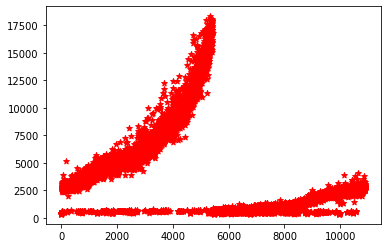

In [23]:
plt.scatter(range(len(Result)),Result,marker='*',c='r')

In [24]:
R = pd.DataFrame({'Unnamed: 0' : id , 'price' : Result})

In [25]:
R.to_csv("result.csv" , index=False)